In [60]:
# prepare data for snntorch
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from torch.utils.data import DataLoader

import snntorch as snn
import torch

sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']
CORE_COUNT : int = cpu_count()
print(f"Number of cores used: {CORE_COUNT}")

def get_length(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return mfccs.shape[1]

def determine_fixed_length(directory):
    file_paths = []

    for subdir in sub_dirs:
        for file in tqdm(os.listdir(os.path.join(directory, subdir))):
            file_path = os.path.join(directory, subdir, file)
            file_paths.append(file_path)

    # Utilize multiprocessing for faster computation
    with ProcessPoolExecutor() as executor:
        lengths = list(executor.map(get_length, file_paths))
    
    return min(lengths)

def parallel_data_loader(directories):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(parallel_load_and_preprocess, directories), total=len(directories)))
    return results

def load_and_preprocess_data_subdir(args):
    directory, subdir = args
    data = []
    labels = []
    
    for file in os.listdir(os.path.join(directory, subdir)):
        file_path = os.path.join(directory, subdir, file)
        processed_data = preprocess_audio(file_path)
        data.append(processed_data)
        label = sub_dirs.index(subdir)
        labels.append(label)
    
    return data, labels

def parallel_load_and_preprocess(directory):
    # Create a pool of processes
    pool = Pool(CORE_COUNT)

    # Create a list of tasks
    tasks = [(directory, time_sig) for time_sig in sub_dirs]

    # Use imap_unordered to distribute the work among the processes
    results = list(tqdm(pool.imap_unordered(load_and_preprocess_data_subdir, tasks), total=len(tasks), mininterval=0.01))

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Combine results
    combined_data = []
    combined_labels = []
    
    for data, labels in results:
        combined_data.extend(data)
        combined_labels.extend(labels)
    
    return combined_data, combined_labels


def adjust_fixed_length(features, timesteps):
    # If the array is 1-dimensional
    if len(features.shape) == 1:
        if features.shape[0] > timesteps:
            return features[:timesteps]
        elif features.shape[0] < timesteps:
            padding = np.zeros(timesteps - features.shape[0])
            return np.hstack((features, padding))
        return features
    # If the array is 2-dimensional
    else:
        # If the time axis of the 2D array is greater than timesteps, crop it.
        if features.shape[1] > timesteps:
            return features[:, :timesteps]
        # If the time axis of the 2D array is less than timesteps, pad it.
        elif features.shape[1] < timesteps:
            padding = np.zeros((features.shape[0], timesteps - features.shape[1]))
            return np.hstack((features, padding))
        return features


# # Process the audio file into desired features
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    
    # Extracting onset strength
    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    onset_strength = adjust_fixed_length(onset_strength, fixed_timesteps)
    onset_strength_normalized = (onset_strength - np.min(onset_strength)) / (np.max(onset_strength) - np.min(onset_strength))
    
    # # # Extracting tempogram
    # tempogram = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr)
    # tempogram_adjusted = adjust_fixed_length(tempogram, fixed_timesteps)
    # tempogram_normalized = (tempogram_adjusted - np.min(tempogram_adjusted)) / (np.max(tempogram_adjusted) - np.min(tempogram_adjusted))
    
    # Stacking features vertically (here, you might choose to stack them differently depending on your application)
    # combined_features = np.vstack([onset_strength_normalized, tempogram_normalized])
    combined_features = np.vstack(onset_strength_normalized)
    return combined_features

# def preprocess_audio(file_path):
#     y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    
#     # Extracting onset strength
#     onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
#     onset_strength_adjusted = adjust_fixed_length(onset_strength, fixed_timesteps)
#     onset_strength_normalized = (onset_strength_adjusted - np.min(onset_strength_adjusted)) / (np.max(onset_strength_adjusted) - np.min(onset_strength_adjusted))
    
#     # Extracting BPM (Tempo)
#     tempo, _ = librosa.beat.beat_track(onset_envelope=onset_strength, sr=sr)
    
#     # Normalizing tempo
#     max_tempo = 200.0  # Assume a reasonable max tempo (you may need to adjust this)
#     tempo_normalized = tempo / max_tempo
    
#     # Making it a 2D array to match the dimensions of onset_strength_normalized
#     tempo_feature = np.full((1, onset_strength_normalized.shape[0]), tempo_normalized)
    
#     # Check shapes
#     # print("Onset Strength Shape:", onset_strength_normalized.shape)
#     # print("Tempo Shape:", tempo_feature.shape)
    
#     # Combine onset strength and BPM
#     onset_strength_normalized = onset_strength_normalized.reshape(1, -1)  # reshaping to make it a 2D array
    
#     combined_features = np.vstack([onset_strength_normalized, tempo_feature])

#     return combined_features


def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

       

DIRTY = True

 

# checking shapes
print("Checking shapes...")

training_data_path = 'training_data_dirty_bpm' if DIRTY else 'training_data_clean'
validation_data_path = 'validation_data_dirty_bpm' if DIRTY else 'validation_data_clean'

fixed_timesteps = determine_fixed_length(training_data_path)
print(fixed_timesteps)
# fixed_timesteps2 = determine_fixed_length(validation_data_path)
# print(fixed_timesteps2)
# fixed_timesteps = max(fixed_timesteps, fixed_timesteps2)
# 1. Load and preprocess data
print("Loading and preprocessing training data...")
directories = [training_data_path, validation_data_path]
training_data_results, validation_data_results = parallel_data_loader(directories)

training_data, training_labels = training_data_results
validation_data, validation_labels = validation_data_results
print("\nDone with preprocessing!")


from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        sample = torch.tensor(sample, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return sample, label
    
    
batch_size = 256

print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)



Number of cores used: 16
Checking shapes...


100%|██████████| 1000/1000 [00:00<00:00, 792424.71it/s]


240
Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]





100%|██████████| 6/6 [01:11<00:00, 11.93s/it]

100%|██████████| 2/2 [01:12<00:00, 36.23s/it]


Done with preprocessing!
preparing data loaders with batch size 128


torch.Size([50, 6000, 240, 1])


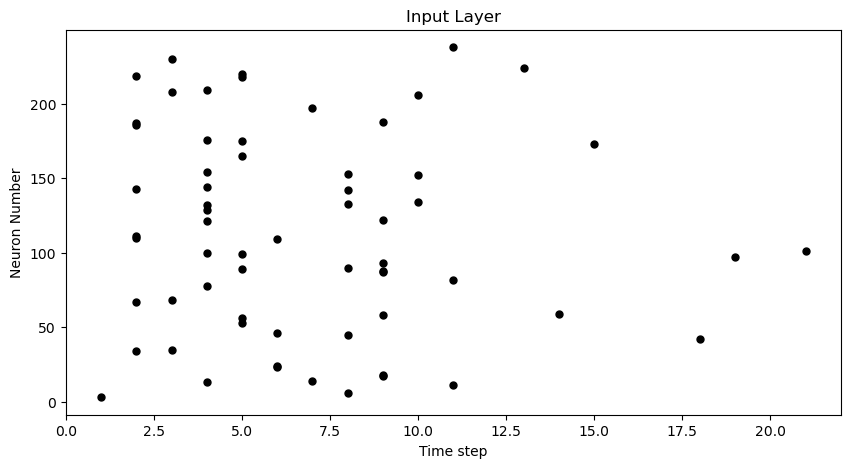

In [73]:
# spike train visualization
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
from snntorch import spikegen

# Initialize lists to store data points for each time signature
training_data_1_4 = []
training_data_2_4 = []
training_data_3_4 = []
training_data_4_4 = []
training_data_4_4 = []
training_data_4_4 = []

# # Iterate through training data and corresponding labels to segregate data
# for i, label in enumerate(training_labels):
#     if label == 0:  # Corresponds to '1_4'
#         training_data_1_4.append(training_data[i])
#     elif label == 1:  # Corresponds to '2_4'
#         training_data_2_4.append(training_data[i])
#     elif label == 2:  # Corresponds to '3_4'
#         training_data_3_4.append(training_data[i])
#     elif label == 3:  # Corresponds to '4_4'
#         training_data_4_4.append(training_data[i])
        

# # Now you have four lists, one for each time signature
# print(f"1/4: {len(training_data_1_4)}")
# print(f"2/4: {len(training_data_2_4)}")
# print(f"3/4: {len(training_data_3_4)}")
# print(f"4/4: {len(training_data_4_4)}")

num_steps = 50
tau = 5
threshold = 0.3   
clip = True

def convert_to_time(data, tau=tau, threshold=threshold):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

# Convert list of numpy arrays to a single numpy array
training_data_np = np.array(training_data)

# Convert numpy array to PyTorch tensor
raw_input = torch.tensor(training_data_np, dtype=torch.float32)

spike_times = convert_to_time(raw_input)


# # Step 4: Reduce Dimensionality for Plotting
# plt.plot(raw_input[0, :, 0].numpy(), spike_times[0, :, 0].numpy())
# plt.xlabel('Input Value')
# plt.ylabel('Spike Time (s)')
# plt.show()

spike_data = spikegen.latency(raw_input, num_steps=num_steps, tau=tau, threshold=threshold, normalize=True, clip=True)
print(spike_data.shape)


fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [128]:
# net initialization
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

from snntorch import spikegen

import torch
import torch.nn as nn
from torchvision import datasets, transforms



import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython.display import clear_output

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


spike_grad = surrogate.fast_sigmoid(slope=25)
# Network Architecture
num_features = 1  # onset_strength and BPM # pnly onset_strength # surrogate + onset
num_inputs = num_features * fixed_timesteps 
print(f"Input Layer Size: {num_inputs} Neurons")
num_hidden = 1000
num_outputs = 6

# neuron and simulation parameters
# spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.95
num_steps = 50

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad) # surrogate = bad
        # self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad) # surrogate = bad
        # self.lif2 = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    clear_output(wait=True)  # This will clear the output of the cell where the function is called
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")
    
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))

# 50 time steps, 10 samples of data, 4 output neurons
print(mem_rec.size())

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)
    
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()


# calculate new network outputs using the same data
data, targets = next(iter(train_loader))
print(f"SNN input shape: {data.shape}")
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)
  

print(f"Training loss: {loss_val.item():.3f}")

print_batch_accuracy(data, targets, train=True)

Input Layer Size: 240 Neurons
torch.Size([50, 200, 6])
Training loss: 106.628
Train set accuracy for a single minibatch: 15.50%
SNN input shape: torch.Size([200, 240, 1])
Training loss: 98.548
Train set accuracy for a single minibatch: 18.50%


# training short

Epoch 49, Iteration 20
Train Set Loss: 10.64
Test Set Loss: 11.41
Train set accuracy for a single minibatch: 54.50%
Test set accuracy for a single minibatch: 61.50%




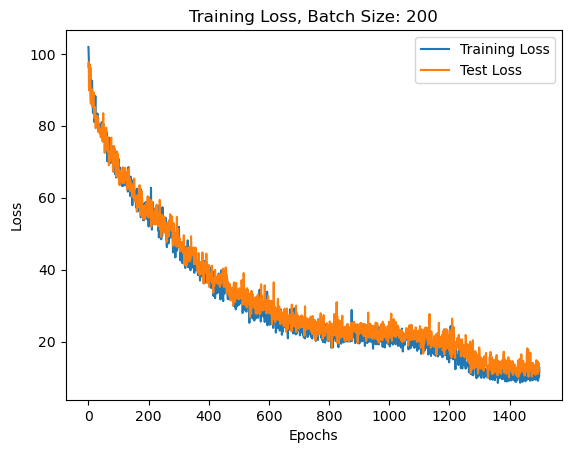

In [129]:
# train the network for 10 epochs then plot the loss
num_epochs = 50
loss_hist = []
test_loss_hist = []
counter = 0
tau = 5
threshold = 0.3   
clip = True

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        
        # # Latency encoding
        # input_latency_encoded = spikegen.latency(data, num_steps=num_steps, tau=tau, threshold=threshold, normalize=True, clip=clip)
        # print(input_latency_encoded.shape)
        
        # # feed data into the network
        # spk_rec, mem_rec = net(input_latency_encoded.view(batch_size, -1))
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 10 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
            
plt.title(f"Training Loss, Batch Size: {batch_size}")
plt.plot(loss_hist, label="Training Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [127]:
# adjust batchsize if needed
batch_size = 200

  
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Epoch 9, Iteration 13
Train Set Loss: 11.34
Test Set Loss: 14.96
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 84.38%




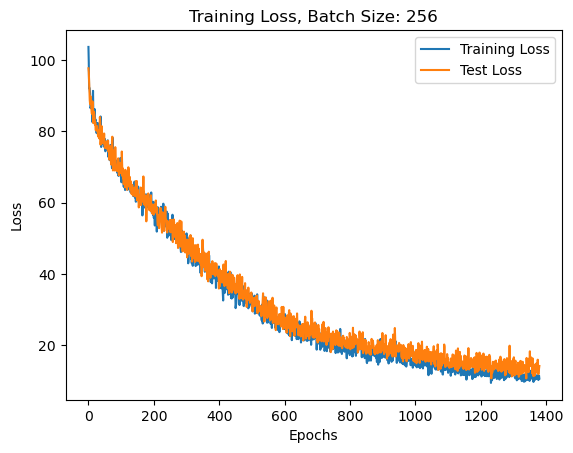

In [106]:
# second training if needed
num_epochs = 10

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 10 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
            
plt.title(f"Training Loss, Batch Size: {batch_size}")           
plt.plot(loss_hist, label="Training Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

eval

SNN - Total correctly classified test set images: 3429/6000
 Test Set Accuracy: 57.15%


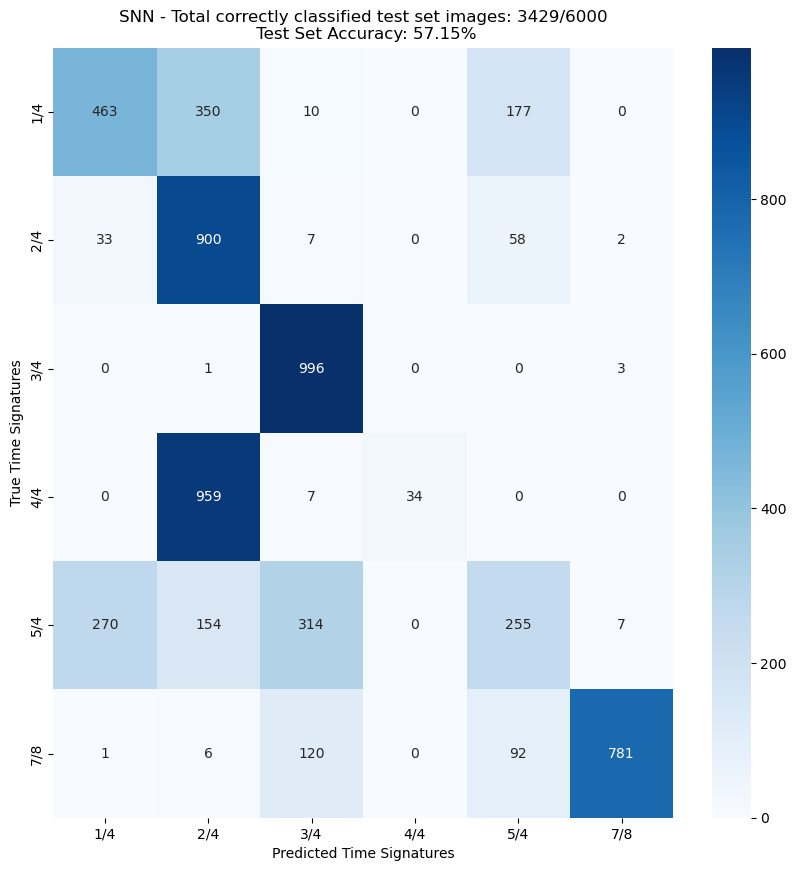

In [130]:
# evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

confidence_threshold = 0.0  # Set your confidence threshold


total = 0
correct = 0

true_labels = []
predicted_labels = []
predicted_percentages = []

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # Calculate spike sums and get the maximum across neurons for each example
        spike_sums = test_spk.sum(dim=0)
        _, predicted = spike_sums.max(1)

        # Normalize spike sums to get "confidence percentages"
        spike_sums = (spike_sums / spike_sums.sum(dim=1, keepdim=True)) * 100
        predicted_percentage = spike_sums[np.arange(spike_sums.shape[0]), predicted].cpu().numpy()
        # Skip low-confidence predictions
        for i in range(len(predicted)):
            if predicted_percentage[i] < confidence_threshold:
                continue
            total += 1
            correct += (predicted[i] == targets[i]).item()
            true_labels.append(targets[i].item())
            predicted_labels.append(predicted[i].item())
            predicted_percentages.append(predicted_percentage[i])
    

result = f"SNN - Total correctly classified test set images: {correct}/{total}\n Test Set Accuracy: {100 * correct / total:.2f}%"
print(result)


# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define your custom labels
custom_labels = ['1/4', '2/4', '3/4', '4/4', '5/4', '7/8']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 10))
plt.title(result)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Time Signatures')
plt.ylabel('True Time Signatures')
plt.show()

save the net

In [50]:
# Save model state_dict
torch.save(net.state_dict(), f"snn_hidden{num_hidden}_{100 * correct / total:.2f}.pth")

# CNN

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)  # Here, input channel is 1, output channel is 32
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32*120, 1000)  # Adjust dimensions based on your actual Conv1d and Pool output shape
        self.fc2 = nn.Linear(1000, 6)  # 6 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32*120)  # Flatten; adjust dimensions based on your actual Conv1d and Pool output shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Assuming `train_loader` and `test_loader` are your data loaders
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize CNN model and loss function
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=5e-4)

EPOCH_CNT = 50
# Training Loop
for epoch in range(EPOCH_CNT):  # 10 epochs; you can change this
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        reshaped_data = data.view(256, 1, 240)  # reshape to fit into CNN

        outputs = cnn_model(reshaped_data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:  # Print loss every 10 batches
            print(f'Epoch [{epoch+1}/{EPOCH_CNT}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end="\r")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        reshaped_data = data.view(256, 1, 240)  # reshape to fit into CNN

        outputs = cnn_model(reshaped_data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy of the CNN on test set: {100 * correct / total}%')


Epoch [1/50], Step [1/23], Loss: 1.8035
Epoch [1/50], Step [11/23], Loss: 1.8064
Epoch [1/50], Step [21/23], Loss: 1.7813
Epoch [2/50], Step [1/23], Loss: 1.7805
Epoch [2/50], Step [11/23], Loss: 1.7719
Epoch [2/50], Step [21/23], Loss: 1.7500
Epoch [3/50], Step [1/23], Loss: 1.7402
Epoch [3/50], Step [11/23], Loss: 1.7194
Epoch [3/50], Step [21/23], Loss: 1.6520
Epoch [4/50], Step [1/23], Loss: 1.6183
Epoch [4/50], Step [11/23], Loss: 1.6051
Epoch [4/50], Step [21/23], Loss: 1.5412
Epoch [5/50], Step [1/23], Loss: 1.4900
Epoch [5/50], Step [11/23], Loss: 1.4198
Epoch [5/50], Step [21/23], Loss: 1.3907
Epoch [6/50], Step [1/23], Loss: 1.3573
Epoch [6/50], Step [11/23], Loss: 1.3026
Epoch [6/50], Step [21/23], Loss: 1.2918
Epoch [7/50], Step [1/23], Loss: 1.2052
Epoch [7/50], Step [11/23], Loss: 1.2071
Epoch [7/50], Step [21/23], Loss: 1.2219
Epoch [8/50], Step [1/23], Loss: 1.1558
Epoch [8/50], Step [11/23], Loss: 1.0673
Epoch [8/50], Step [21/23], Loss: 1.1346
Epoch [9/50], Step [1/23

In [116]:
EPOCH_CNT = 10
# Training Loop
for epoch in range(EPOCH_CNT):  # 10 epochs; you can change this
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        reshaped_data = data.view(256, 1, 240)  # reshape to fit into CNN

        outputs = cnn_model(reshaped_data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:  # Print loss every 10 batches
            print(f'Epoch [{epoch+1}/{EPOCH_CNT}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end="\r")

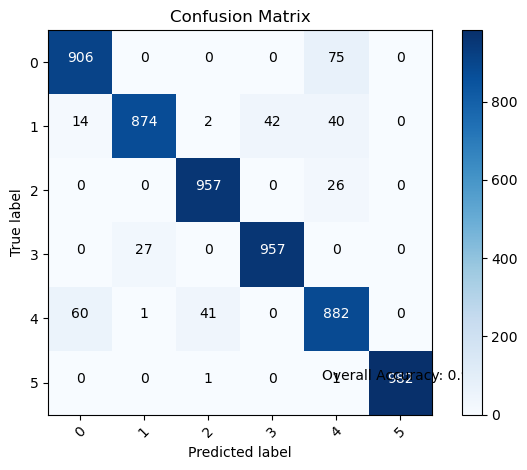

In [125]:
all_targets = []
all_predicted = []

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        reshaped_data = data.view(256, 1, 240)  # reshape to fit into CNN
        outputs = cnn_model(reshaped_data)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())


cm = confusion_matrix(all_targets, all_predicted)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Add overall accuracy to the plot
    overall_accuracy = np.trace(cm) / np.sum(cm)
    plt.text(cm.shape[1] - 1, cm.shape[0] - 1, f'Overall Accuracy: {overall_accuracy:.2f}', 
             horizontalalignment="center",
             verticalalignment="bottom",
             color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Use your confusion matrix (cm) and class names here
class_names = [0, 1, 2, 3, 4, 5]
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix CNN')

In [131]:
import time

cnt = 0
t = 10
start_time = time.time()
for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        reshaped_data = data.view(256, 1, 240)  # reshape to fit into CNN

        cnt += 1
        outputs = cnn_model(reshaped_data)
        if cnt == t:
            pass
end_time = time.time()

latency = end_time - start_time

print(f"Latency CNN: {latency:.2f} seconds")


cnt = 0
t = 10

with torch.no_grad():
    net.eval()
    start_time = time.time()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        test_spk, _ = net(data.view(data.size(0), -1))
        cnt += 1
        outputs = cnn_model(reshaped_data)
        if cnt == t:
            pass
end_time = time.time()

latency = end_time - start_time

print(f"Latency SNN: {latency:.2f} seconds")

RuntimeError: shape '[256, 1, 240]' is invalid for input of size 48000